# "Implémentez un modèle de scoring"
_Cleaning the data_


References used for this notebook:

- "https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda"

## Setup

### Imports

In [429]:
%pwd

'C:\\Users\\Maryse\\Documents\\o---FORMATION---o\\OCR_DS\\PROJET 7 - Mod Scoring\\PROJECT 7\\NOTEBOOKS'

Installations and importations required in the virtual environment.

In [2]:
from P7_functions import *

In [3]:
from custtransformer import *

Importation of modules and packages. 

In [4]:
import io
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [5]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

Additional functions

In [6]:
# To play audio text-to-speech during execution

from IPython.display import Audio
# from gtts import gTTS

# def speak(text, lang='en'):
#     with io.BytesIO() as f:
#         gTTS(text=text, lang=lang).write_to_fp(f)
#         f.seek(0)
#         return Audio(f.read(), autoplay=True)

## Read Data

In [7]:
# ### Pickling the aggregated dataset

# import dill

# with open('dict_df_agg.pkl', 'wb') as file:
#     dill.dump(dict_df, file)

In [8]:
### Importation

import dill

with open('../data/cleaned/dict_df_agg.pkl', 'rb') as file:
    dict_df = dill.load(file)

In [9]:
dict_df.keys()

dict_keys(['X_train', 'y_train', 'X_test'])

In [10]:
X_train = dict_df['X_train'].copy('deep')
X_test = dict_df['X_test'].copy('deep')
y_train = dict_df['y_train'].copy('deep')

In [11]:
#### Exploring values of the remaining columns

# get categorical and quantitative columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns
quant_cols = X_train.select_dtypes(include=[np.number]).columns

# get binary columns
bin_cols = X_train.columns[X_train.nunique()==2]

# get integer columns
int_cols = \
    [c for c in X_train.select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
# get float columns
f64_cols = \
    [c for c in X_train.select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()<100]
f64_high_nunique = \
    X_train[f64_cols].columns\
            [X_train[f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

In [12]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [13]:
quant_cols

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH',
       ...
       'PA_OUTSTANDING_LOAN__sum', 'PA_OUTSTANDING_LOAN__size', 'PA_AMT_DIFF_PCT__mean',
       'PA_AMT_DIFF_PCT__max', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
       'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CNT_FAM_MEMBERS_NOT_CHILD'],
      dtype='object', length=212)

In [14]:
'DAYS_BIRTH' in X_train.select_dtypes(exclude=[np.number]).columns

False

## Missing data

### Global view

<AxesSubplot:ylabel='SK_ID_CURR'>

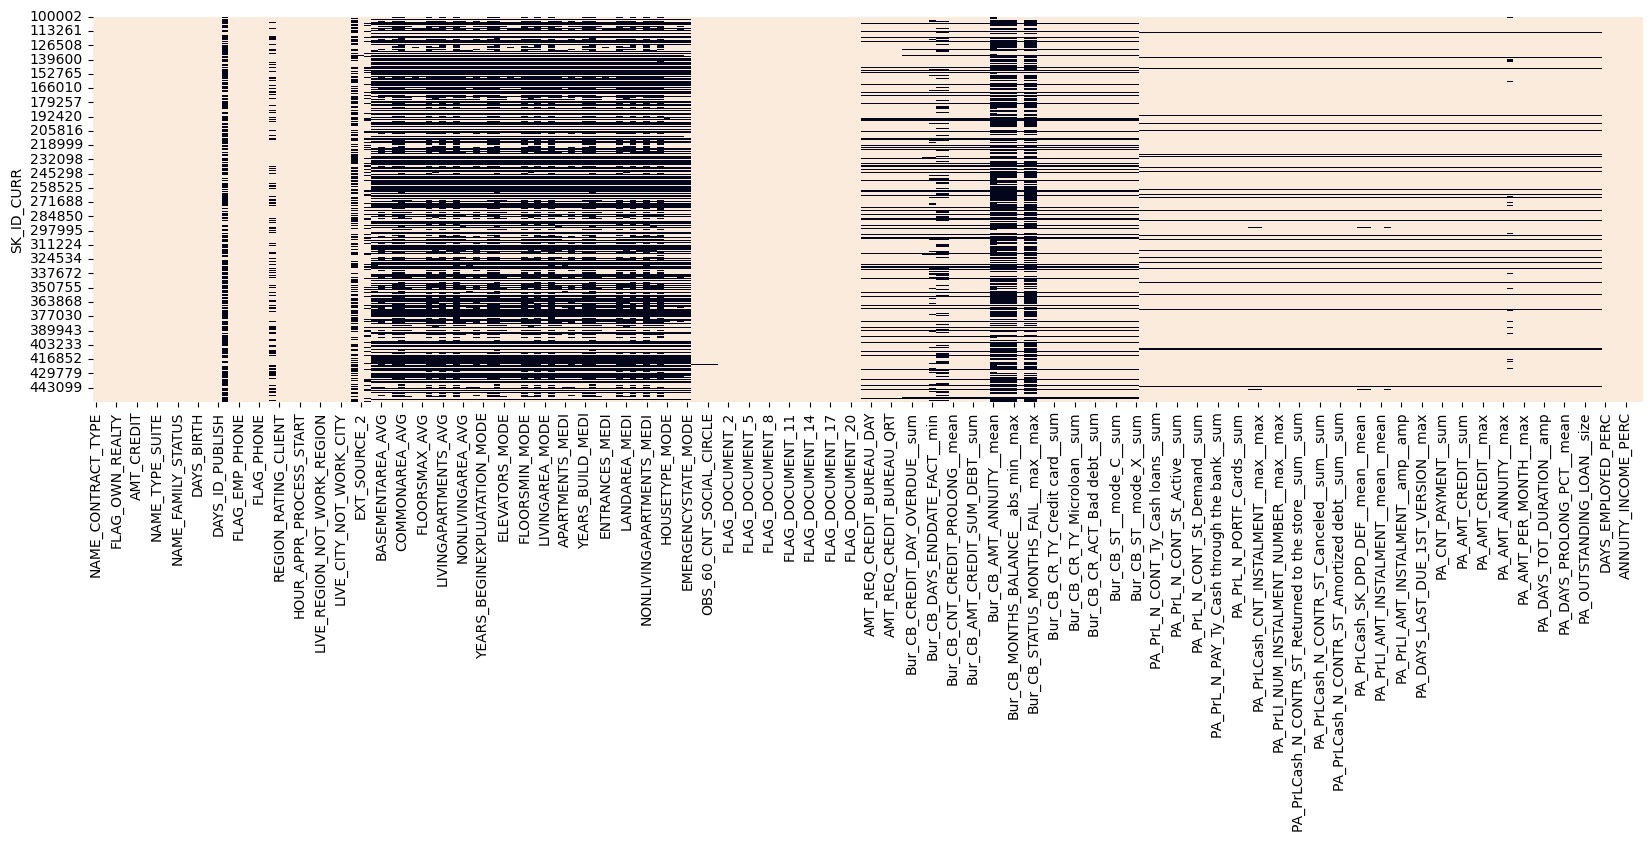

In [15]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(X_train.notna(), cbar=False)

In [16]:
# Have a overview of the missing values

df_miss = missing_data(X_train)

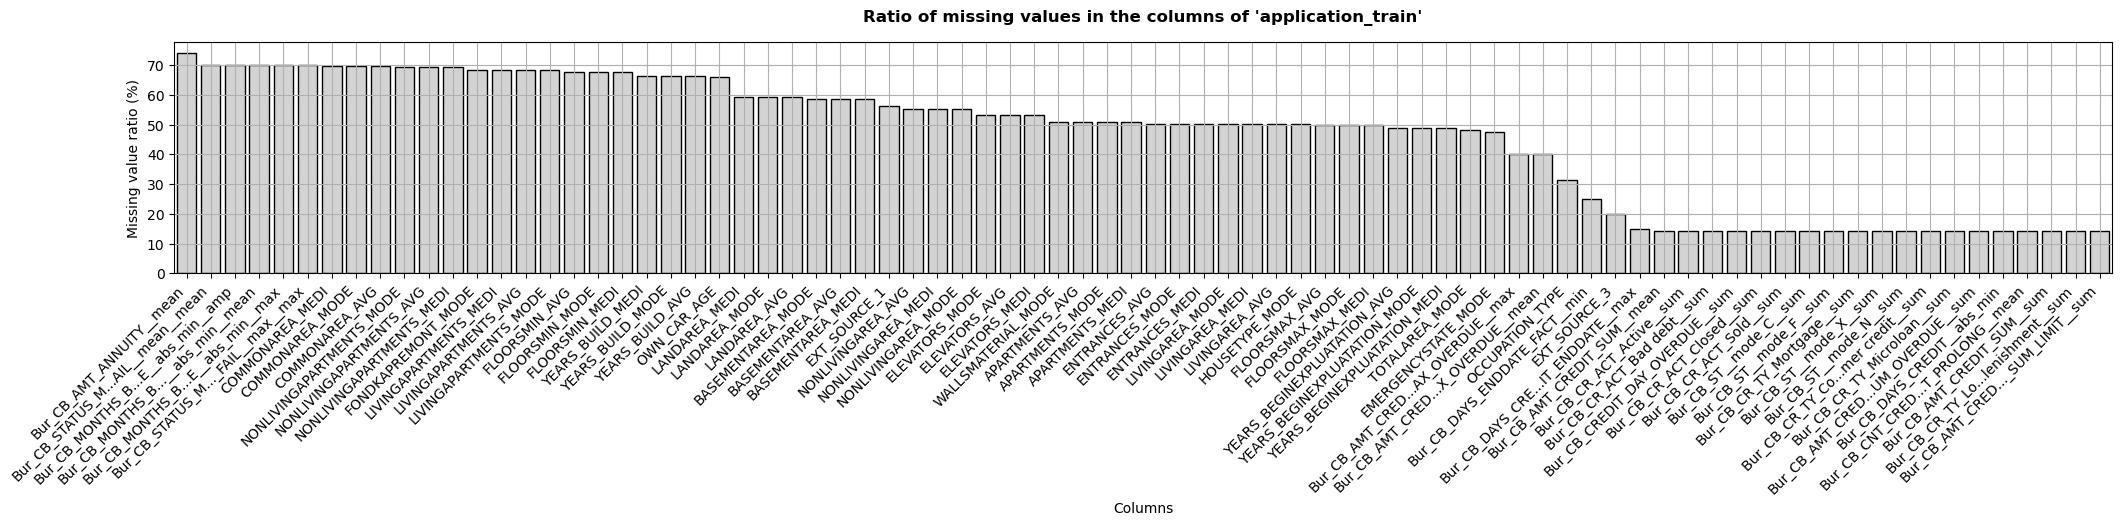

In [17]:
plot_simple_barplot(x = df_miss.index[:80],
                    y = df_miss['Percent'].iloc[:80],
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(25,3), color='lightgrey')

In [18]:
# display the number and the name of the columns to delete because exceeding 50% missing values

miss_more_45_cols = X_train[df_miss[df_miss['Percent']>45].index].columns
print(len(miss_more_45_cols), list(miss_more_45_cols))

55 ['Bur_CB_AMT_ANNUITY__mean', 'Bur_CB_STATUS_MONTHS_FAIL__mean__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__amp', 'Bur_CB_MONTHS_BALANCE__abs_min__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__max', 'Bur_CB_STATUS_MONTHS_FAIL__max__max', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'EXT_SOURCE_1', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'WALLSMATERIAL_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'LIVINGAREA_MODE', 'LIVINGAREA_

In [19]:
'DAYS_BIRTH' in X_train.select_dtypes(exclude=[np.number]).columns

False

In [20]:
X_train.dtypes.value_counts()

float64    173
int64       39
object      16
dtype: int64

In [21]:
X_train.select_dtypes(exclude=[np.number]).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

### Convert Infinite values to nan

In [22]:
# test = pd.DataFrame([[1,2,np.inf,4], [5,6,7,np.nan], [9,np.nan,11,np.inf]])

# mask = pd.DataFrame(np.isfinite(test.values), # infini et notna -> False sinon True
#                     index=test.index,
#                     columns=test.columns).replace({False: np.nan})

# # if infinite value -> set to np.nan
# test = test.mul(mask)

# # change back the type of the columns to numeric
# test = test.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)
# test

In [23]:
# get rid of the infinite values in X_train

mask = pd.DataFrame(np.isfinite(X_train[quant_cols].values), # infini et notna -> False sinon True
                    index=X_train.index,
                    columns=quant_cols).replace({False: np.nan})
# if infinite value -> set to np.nan
X_train[quant_cols] = X_train[quant_cols].mul(mask)
# change back the type of the columns to numeric
X_train = X_train.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)

In [24]:
# get rid of the infinite values in X_test

mask = pd.DataFrame(np.isfinite(X_test[quant_cols].values), # infini et notna -> False sinon True
                    index=X_test.index,
                    columns=quant_cols).replace({False: np.nan})
# if infinite value -> set to np.nan
X_test[quant_cols] = X_test[quant_cols].mul(mask)
# change back the type of the columns to numeric
X_test = X_test.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)


## OLD
# mask_notfinite = pd.DataFrame(~np.isfinite(X_test[quant_cols].values))
# mask_notna = X_test[quant_cols].notna()
# mask = pd.DataFrame(~(mask_notfinite.values & mask_notna.values),
#                     index=X_test.index,
#                     columns=quant_cols).replace({False: np.nan})

# X_test[quant_cols] = X_test[quant_cols].mul(mask)

### Remove features with too much data missing

In [25]:
# see nb of columns before dropping

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(176, 52)

In [26]:
# keep only features with more than 55% notna values

X_train = X_train.drop(columns=miss_more_45_cols)
X_test = X_test.drop(columns=miss_more_45_cols)

### Imputation

In [27]:
# see nb of columns after dropping features with less than 55% notna

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(121, 52)

In [28]:
'DAYS_BIRTH' in X_train.select_dtypes(exclude=[np.number]).columns

False

#### Quantitative

In [29]:
# case 0 : columns coming from aggregation (__sum, __mean, __max, __min, __size, __sum, _amp, __abs_min )

cols_agg = X_train.columns[X_train.columns.str.contains(
        '__sum|__max|__min|__mean|__size|__sum|__amp|__abs_min')]

X_train[cols_agg] = X_train[cols_agg].fillna(0)
X_test[cols_agg] = X_test[cols_agg].fillna(0)

miss_cols = [col for col in miss_cols if col not in cols_agg]

In [30]:
# case 1 continuous numerical values
miss_numb_cols = X_train[miss_cols].select_dtypes(include=[np.number]).columns

# case 1.1: almost totally filled (>99%), can be easily infered (median)
miss_few_numb_cols = ser_miss.loc[miss_numb_cols][ser_miss.loc[miss_numb_cols]<1].index

for c in miss_few_numb_cols:
    median = X_train[c].median()
    X_train[c] = X_train[c].fillna(median)
    X_test[c] = X_test[c].fillna(median)

In [31]:
# case 1.2: between 1% and 32%

miss_much_numb_cols = ser_miss.loc[miss_numb_cols][ser_miss.loc[miss_numb_cols]>=1].index

# some of these quantitative columns have in fact few unique values -> to categories

miss_numb_to_cat = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
miss_much_numb_cols = [col for col in miss_much_numb_cols if col not in miss_numb_to_cat]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, f_classif

for col in miss_much_numb_cols:
    
    print(f'-----{col}')
    
    ind_no_miss = list(X_train[X_train[col].notna()].index)
    ind_miss = list(X_train[X_train[col].isna()].index)
    
    # select features for knn inference unsing SelectKBest
    sel_k = SelectKBest(k=8, score_func=f_regression)

    num_filled_col = X_train[no_miss_cols].select_dtypes(include=[np.number]).columns
    sel_k.fit(X_train.loc[ind_no_miss, num_filled_col], X_train.loc[ind_no_miss, col])
    best_cols = list(num_filled_col[sel_k.get_support(indices=True)])
    print("features used for the model", best_cols)

    # machine learning model imputer
    var_model = best_cols
    var_target = col
    ind_sample = random.sample(ind_no_miss, 5000) + ind_miss
    ind_to_impute, y_pr_ = model_impute(X_train.loc[ind_sample],
                                        var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label',
                                        n_model='rf', plot=False)
    print('-> Number of values to impute:', len(ind_to_impute))

#     # replace nan values
#     X_train.loc[ind_to_impute, col] = y_pr_

-----EXT_SOURCE_3


c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


features used for the model ['DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'DAYS_EMPLOYED_PERC', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY']
--- model: -0.016
--- normal random distribution: -33.7
--- dummy regressor (mean) : r2_score=-0.00378
--- dummy regressor (median) : r2_score=-0.00163
-> Number of values to impute: 60965


The models (either knn or random forest) to impute 'EXT_SOURCE_3' are very inaccurate... we replace nan values with mean.

In [32]:
# replace nan values with mean
for col in miss_much_numb_cols:
    mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean)
    X_test[col] = X_test[col].fillna(mean)

In [33]:
# see missing rate after filling quantitative missing values

ser_miss = missing_data(X_train)['Percent']
no_miss_cols = ser_miss.loc[ser_miss==0].index
miss_cols = [col for col in X_train.columns if col not in no_miss_cols]
len(miss_cols), len(no_miss_cols)

(11, 162)

#### Categorical

In [34]:
# case 2 categories
miss_cat_cols = X_train[miss_cols].select_dtypes(exclude=[np.number]).columns

# case 2.1: almost totally filled (>99%), can be easily infered (more frequent)
miss_few_cat_cols = ser_miss.loc[miss_cat_cols][ser_miss.loc[miss_cat_cols]<1].index

for c in miss_few_cat_cols:
    mode = X_train[c].mode()[0]
    X_train[c] = X_train[c].fillna(mode)
    X_test[c] = X_test[c].fillna(mode)

We tried KNN imputation on the categorical column 'OCCUPATION_TYPE' with 32% missing value (see code below) but the score is worse (f1=0.23) than with imputation by most frequent value (f1=0.25).

We thus imputed (see above) using most frequent value.

In [35]:
# # Data preprocessing, Knn training, then predicting (all-in-one function)
# # infer 'OCCUPATION_TYPE' from 25 TARGET most representative columns (SelectKBest)

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression, f_classif

# # X_train[miss_much_cat_cols] = X_train[miss_much_cat_cols].astype('object')

# for col in miss_much_cat_cols:
    
#     print(f'-----{col}')
#     ind_no_miss = list(X_train[X_train[col].notna()].index)
#     ind_miss = list(X_train[X_train[col].isna()].index)
#     # select features for knn inference unsing SelectKBest
#     sel_k = SelectKBest(k=8, score_func=f_classif)
#     num_filled_col = X_train[no_miss_cols].select_dtypes(include=[np.number]).columns
#     sel_k.fit(X_train.loc[ind_no_miss, num_filled_col],
#               X_train.loc[ind_no_miss, col])
#     best_cols = list(num_filled_col[sel_k.get_support(indices=True)])
#     print("features used for the model", best_cols)

#     # machine learning model imputer
#     var_model = best_cols
#     var_target = col
#     ind_sample = random.sample(ind_no_miss, 5000) + ind_miss
#     ind_to_impute, y_pr_ = model_impute(X_train.loc[ind_sample],
#                                         var_model = var_model,
#                                         var_target=var_target,
#                                         enc_strat_cat='label',
#                                         n_model='knn', plot=False)
#     print('-> Number of values to impute:', len(ind_to_impute))

# #     #replace nan values
# #     X_train.loc[ind_to_impute, col] = y_pr_


In [36]:
# case 2.2: missing more than 1%, infered using KNN classifier

miss_much_cat_cols = list(ser_miss.loc[miss_cat_cols][ser_miss.loc[miss_cat_cols]>1].index)
miss_much_cat_cols = miss_much_cat_cols + miss_numb_to_cat

for c in miss_much_cat_cols:
    mode = X_train[c].mode()[0]
    X_train[c] = X_train[c].fillna(mode)

## Feature selection (quantitative columns)

In [37]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

### Remove 'useless' features (based on their description)

In [38]:
# get categorical and quantitative columns

cat_cols = X_train.select_dtypes(exclude=[np.number]).columns
quant_cols = X_train.select_dtypes(include=[np.number]).columns

# remove useless columns

useless_cols = ['WEEKDAY_APPR_PROCESS_START', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_18',
                'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START', 'REGION_RATING_CLIENT'] 

quant_cols = [col for col in quant_cols if col not in useless_cols]
cat_cols = [col for col in cat_cols if col not in useless_cols]

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

### Selection based on Pearson correlation

Correlation beeing scale sensitive, we apply normalization prior Pearson correlation calculation to get a meaningful correlation comparison.

We also drop the outliers for calculation.

In [39]:
# get binary columns
bin_cols = X_train.columns[X_train.nunique()==2]

# get categorical and quantitative columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns
quant_cols = X_train.select_dtypes(include=[np.number]).columns

# exclude binary columns from quantitative columns
quant_cols = [col for col in quant_cols if col not in bin_cols]

In [40]:
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

thresh = 5
minmax = MinMaxScaler()

# Minmax scaling of each column
X_train_norm_wo_out = pd.DataFrame()
for col in quant_cols:
    ser_ = X_train[col]
    mask_outl = np.abs(st.zscore(ser_))<thresh
    ser_ = ser_.loc[mask_outl]
    ser_ = pd.Series(minmax.fit_transform(ser_.to_frame()).reshape(-1),
                                         index=ser_.index,
                                         name=col)
    X_train_norm_wo_out = pd.concat([X_train_norm_wo_out, ser_], axis=1)

# drop all row where value is an outlier in at least one column
mask = X_train_norm_wo_out.isna().any(1)
X_train_norm_wo_out = X_train_norm_wo_out.loc[mask]

In [41]:
# compute Pearson correlation matrix

corr = X_train_norm_wo_out[quant_cols].corr()

In [42]:
# print nb of columns with a high correlation

for thresh in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    li_corr_features = corr[((np.abs(corr)>thresh)&(np.abs(corr)<1)).any(1)].index
    print('---threshold Pearson corr = '+str(thresh)+" -> {} columns".format(str(len(li_corr_features))))
#     print(li_corr_features)

---threshold Pearson corr = 0.3 -> 98 columns
---threshold Pearson corr = 0.4 -> 86 columns
---threshold Pearson corr = 0.5 -> 83 columns
---threshold Pearson corr = 0.6 -> 75 columns
---threshold Pearson corr = 0.7 -> 68 columns
---threshold Pearson corr = 0.8 -> 51 columns
---threshold Pearson corr = 0.9 -> 37 columns
---threshold Pearson corr = 0.99 -> 12 columns


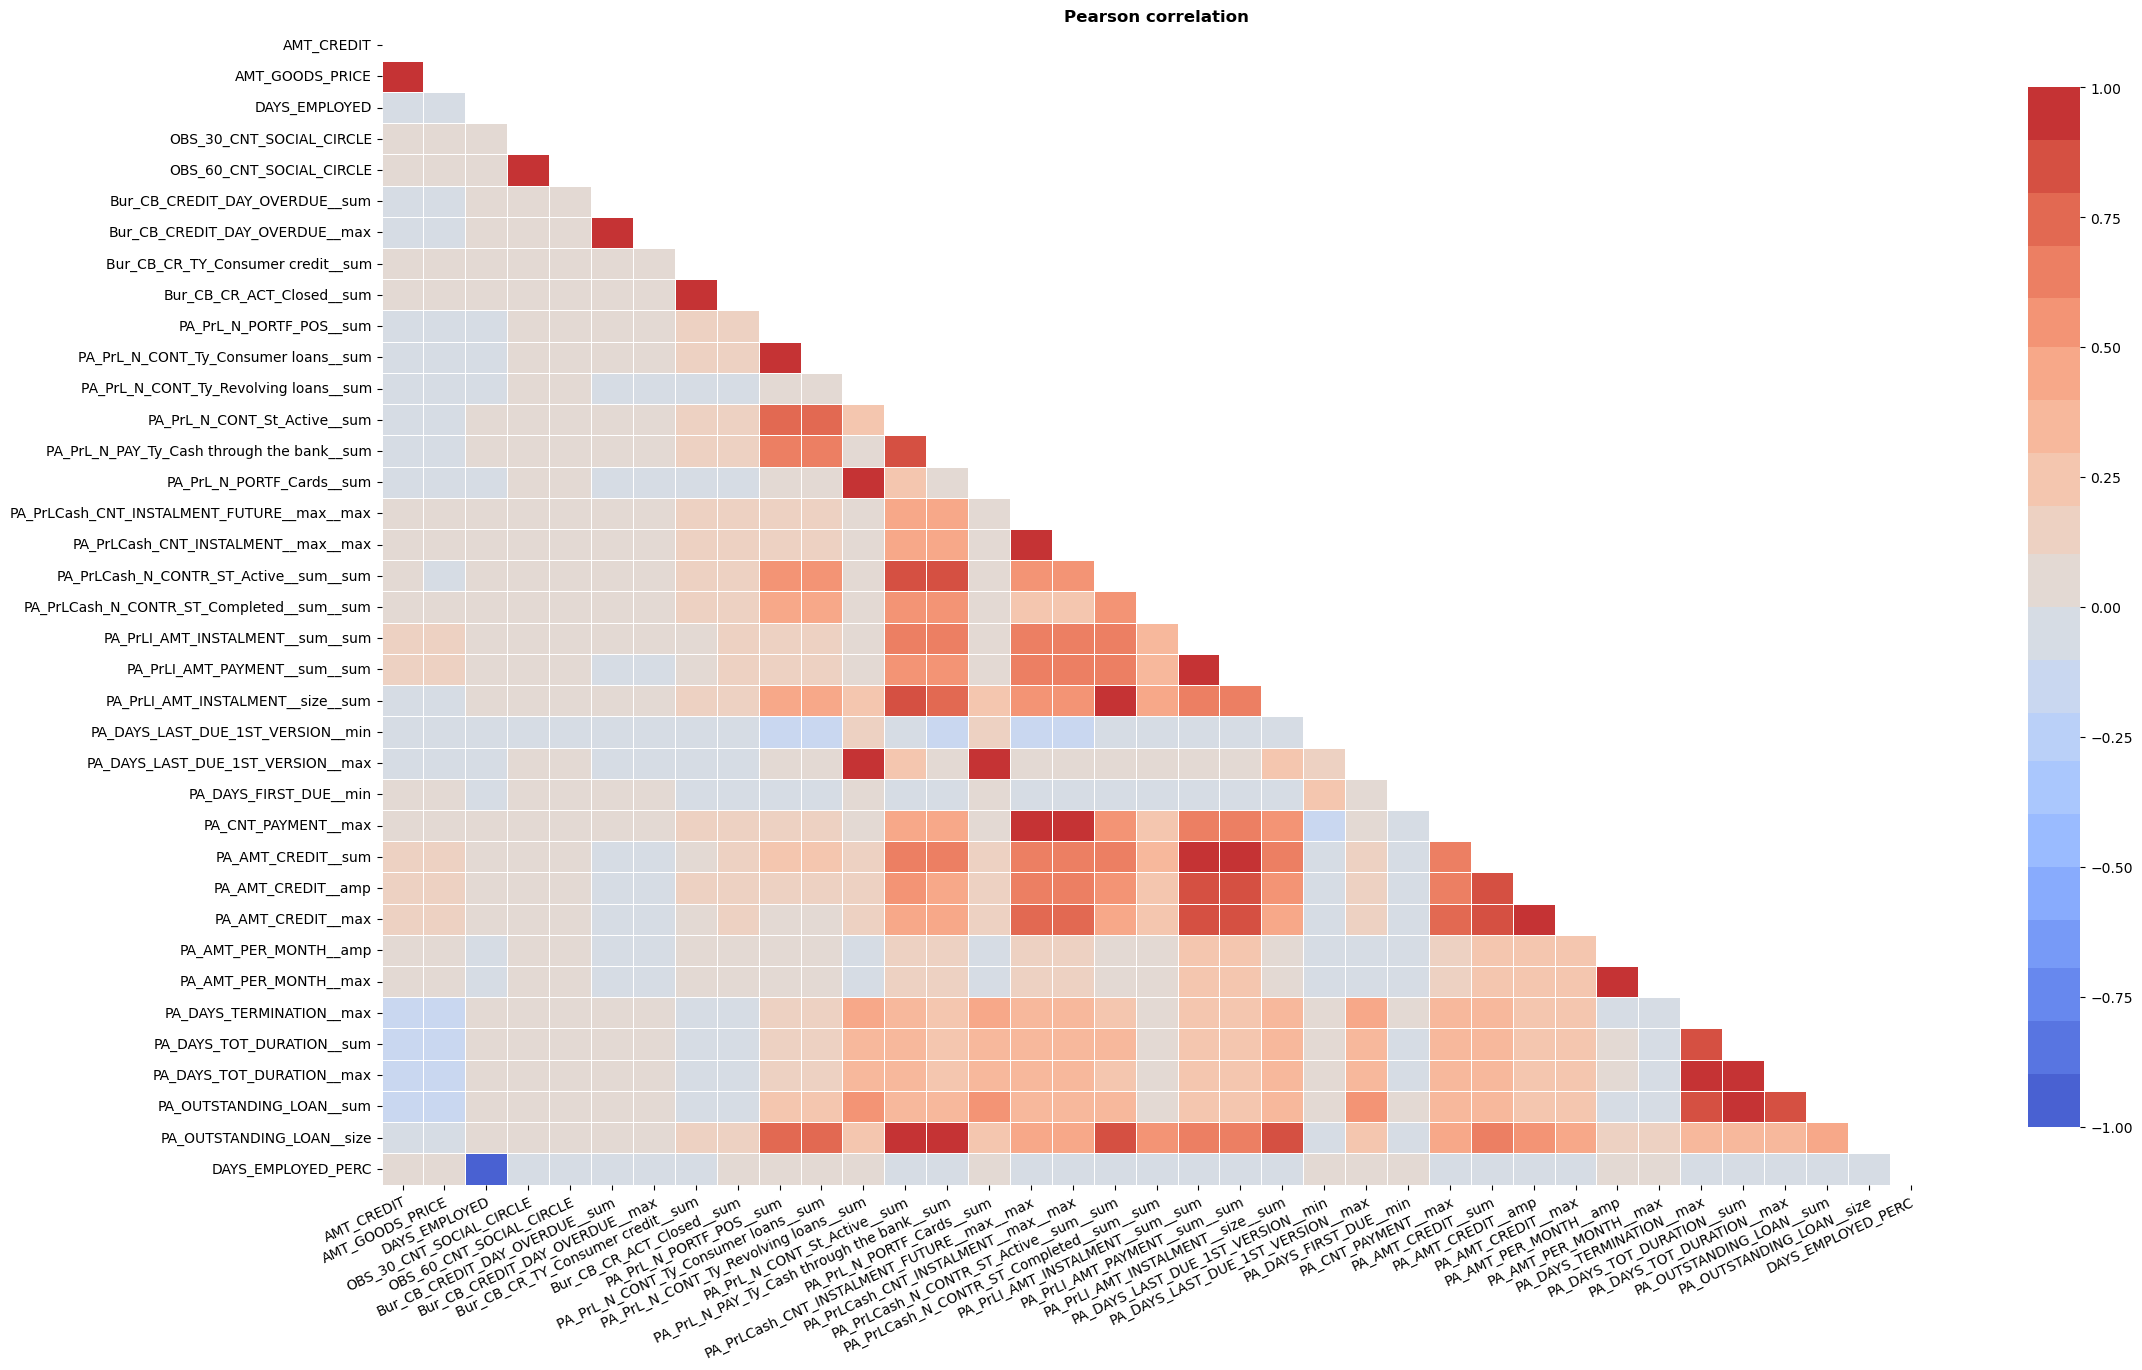

In [43]:
#### Select and vizualize high correlation features (>0.9)

cols_high_corr = corr[((np.abs(corr)>0.9)&(np.abs(corr)<1)).any(1)].index
corr_high_corr = X_train[cols_high_corr].corr()

plot_heatmap(corr_high_corr, 'Pearson correlation', shape='tri', annot=False, fmt='.2f',
             figsize=(25, 15), vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20))

In [44]:
# for each correlated feature, print the list of correlated features
for col in corr_high_corr.columns:
    ser = np.abs(corr_high_corr[col]).sort_values()
    col2 = ser[(ser>0.9)&(ser!=1)].index
    print(col, col2)

AMT_CREDIT Index(['AMT_GOODS_PRICE'], dtype='object')
AMT_GOODS_PRICE Index(['AMT_CREDIT'], dtype='object')
DAYS_EMPLOYED Index(['DAYS_EMPLOYED_PERC'], dtype='object')
OBS_30_CNT_SOCIAL_CIRCLE Index(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype='object')
OBS_60_CNT_SOCIAL_CIRCLE Index(['OBS_30_CNT_SOCIAL_CIRCLE'], dtype='object')
Bur_CB_CREDIT_DAY_OVERDUE__sum Index(['Bur_CB_CREDIT_DAY_OVERDUE__max'], dtype='object')
Bur_CB_CREDIT_DAY_OVERDUE__max Index(['Bur_CB_CREDIT_DAY_OVERDUE__sum'], dtype='object')
Bur_CB_CR_TY_Consumer credit__sum Index(['Bur_CB_CR_ACT_Closed__sum'], dtype='object')
Bur_CB_CR_ACT_Closed__sum Index(['Bur_CB_CR_TY_Consumer credit__sum'], dtype='object')
PA_PrL_N_PORTF_POS__sum Index(['PA_PrL_N_CONT_Ty_Consumer loans__sum'], dtype='object')
PA_PrL_N_CONT_Ty_Consumer loans__sum Index(['PA_PrL_N_PORTF_POS__sum'], dtype='object')
PA_PrL_N_CONT_Ty_Revolving loans__sum Index(['PA_DAYS_LAST_DUE_1ST_VERSION__max'], dtype='object')
PA_PrL_N_CONT_St_Active__sum Index(['PA_OUTSTANDING

Remove one of each correlated features

In [45]:
colin_cols = ['AMT_GOODS_PRICE', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
              'DEF_30_CNT_SOCIAL_CIRCLE', 'Bur_CB_DAYS_ENDDATE_FACT__min', 'Bur_CB_CREDIT_DAY_OVERDUE__max',
              'Bur_CB_AMT_CREDIT_MAX_OVERDUE__mean', 'Bur_CB_CR_ACT_Closed__sum', 'Bur_CB_ST__mode_C__sum',
              'PA_PrL_N_CONT_Ty_Consumer loans__sum', 'PA_CNT_PAYMENT__max', 'PA_DAYS_TOT_DURATION__max',
              'PA_DAYS_TERMINATION__max', 'DAYS_EMPLOYED', 'OBS_30_CNT_SOCIAL_CIRCLE', 'PA_AMT_ANNUITY__max',
              'PA_AMT_ANNUITY__amp', 'PA_AMT_CREDIT__max', 'PA_PrLCash_CNT_INSTALMENT_FUTURE__max__max',
              'PA_PrLCash_CNT_INSTALMENT__max__max', 'PA_CNT_PAYMENT__sum', 'PA_PrLCash_N_CONTR_ST_Active__sum__sum',
              'PA_PrL_N_PAY_Ty_Cash through the bank__sum', 'PA_AMT_CREDIT__amp', 'PA_AMT_PER_MONTH__amp',
              'PA_AMT_PER_MONTH__max', 'PA_PrL_N_CONT_St_Active__sum', 'PA_PrLI_AMT_INSTALMENT__amp__amp',
              'PA_PrLI_AMT_PAYMENT__sum__sum', 'PA_PrLI_DELAY_DAYS_INSTALMENT__amp__amp',
              'PA_PrLI_AMT_INSTALMENT__sum__sum', 'PA_PrLI_AMT_INSTALMENT__size__sum', 'PA_AMT_DIFF_PCT__mean ']

quant_cols = [col for col in quant_cols if col not in colin_cols]
cat_cols = [col for col in cat_cols if col not in colin_cols]

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

Lets' have a look to the name of the remaining columns with Pearson correlation score higher than 0.7:

In [46]:
# print nb of remaining columns with a high correlation factor with at least one other variable

corr = X_train[quant_cols].corr()

high_corr_cols = corr[((np.abs(corr)>0.8)&(np.abs(corr)<1)).any(1)].index
high_corr_cols

Index(['AMT_INCOME_TOTAL', 'PA_PrL_N_CONT_Ty_Revolving loans__sum', 'PA_PrL_N_PORTF_Cards__sum',
       'PA_DAYS_LAST_DUE_1ST_VERSION__max', 'PA_AMT_CREDIT__mean', 'PA_AMT_ANNUITY__mean',
       'PA_DAYS_TOT_DURATION__sum', 'PA_OUTSTANDING_LOAN__sum', 'INCOME_PER_PERSON'],
      dtype='object')

We'll keep these features for now.

### Selection based on variance

#### Variance

In [47]:
# Variance after MinMaxScaling (without outlier Zscore > 5)

import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

thresh = 5
minmax = MinMaxScaler()

tab_ = []
for col in quant_cols:
    ser_ = X_train[col]
    mask_outl = np.abs(st.zscore(ser_))<thresh
    ser_ = minmax.fit_transform(ser_.loc[mask_outl].to_frame()).reshape(-1)
    tab_.append(ser_.var(axis=0)*100) # relative variance (pct)
    
rel_var_df = pd.Series(tab_,
                       index=quant_cols).to_frame(name='rel_var_pct')
    
display(rel_var_df.sort_values('rel_var_pct'))

,rel_var_pct
PA_PrL_N_PAY_Ty_Non-cash from your account__sum,0.00
PA_PrLCash_N_CONTR_ST_Amortized debt__sum__sum,0.00
AMT_REQ_CREDIT_BUREAU_WEEK,0.00
AMT_REQ_CREDIT_BUREAU_DAY,0.00
AMT_REQ_CREDIT_BUREAU_HOUR,0.00
Bur_CB_CR_TY_Loan for business development__sum,0.00
Bur_CB_CR_TY_Loan for working capital replenishment__sum,0.00
PA_PrLCash_N_CONTR_ST_Approved__sum__sum,0.00
PA_PrLCash_N_CONTR_ST_Returned to the store__sum__sum,0.00
Bur_CB_CR_ACT_Sold__sum,0.00


In [48]:
low_var_cols = rel_var_df[rel_var_df['rel_var_pct']<0.005].index
low_var_cols

Index(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'Bur_CB_CR_TY_Loan for business development__sum',
       'Bur_CB_CR_TY_Loan for working capital replenishment__sum', 'Bur_CB_CR_ACT_Sold__sum',
       'Bur_CB_ST__mode_F__sum', 'PA_PrL_N_CONT_St_Signed__sum',
       'PA_PrL_N_PAY_Ty_Cashless from the account of the employer__sum',
       'PA_PrL_N_PAY_Ty_Non-cash from your account__sum',
       'PA_PrLCash_N_CONTR_ST_Returned to the store__sum__sum',
       'PA_PrLCash_N_CONTR_ST_Approved__sum__sum',
       'PA_PrLCash_N_CONTR_ST_Amortized debt__sum__sum'],
      dtype='object')

Let's remove the features with very low variance

In [49]:
quant_cols = [col for col in quant_cols if col not in low_var_cols]
cat_cols = [col for col in cat_cols if col not in low_var_cols]

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

#### Variance inflation factor

In [50]:
# select a sample in order to speed up the permutation_importance calculations

ind = X_train.sample(100000).index
X_train_samp = X_train.loc[ind]

In [51]:
### Feature selection based on colinearity (Variance Inflation Factor)
# Variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms
# by the variance of a model with one term alone. It quantifies the severity of multicollinearity.
# Let's compute the values of VIF for our quantitative features:

from statsmodels.stats.outliers_influence import variance_inflation_factor    

variables = quant_cols
var_inf = pd.Series([variance_inflation_factor(X_train_samp.loc[:, variables].values, ix)\
               for ix in range(len(variables))], index = variables).to_frame(name='var_inflation')
var_inf = var_inf.sort_values('var_inflation')

display(var_inf.sort_values('var_inflation'))

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,var_inflation
Bur_CB_AMT_CREDIT_MAX_OVERDUE__max,1.00
PA_PrLCash_N_CONTR_ST_Demand__sum__sum,1.01
Bur_CB_AMT_CREDIT_SUM_OVERDUE__sum,1.02
Bur_CB_CREDIT_DAY_OVERDUE__sum,1.02
Bur_CB_CR_TY_Microloan__sum,1.03
Bur_CB_CNT_CREDIT_PROLONG__mean,1.04
AMT_REQ_CREDIT_BUREAU_QRT,1.07
PA_PrLCash_SK_DPD_DEF__mean__mean,1.08
PA_DAYS_FIRST_DUE__min,1.12
AMT_REQ_CREDIT_BUREAU_MON,1.13


Let's see the list of the highly correlated features according to VIF

In [52]:
high_vip_cols = var_inf[var_inf['var_inflation']>5].index
high_vip_cols

Index(['PA_DAYS_TOT_DURATION__amp', 'DAYS_ID_PUBLISH', 'Bur_CB_DAYS_CREDIT__abs_min',
       'PA_AMT_DIFF_PCT__max', 'PA_PrLI_AMT_INSTALMENT__mean__mean', 'Bur_CB_CR_ACT_Active__sum',
       'PA_DAYS_PROLONG_PCT__mean', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'EXT_SOURCE_2',
       'PA_DAYS_TOT_DURATION__mean', 'ANNUITY_INCOME_PERC', 'EXT_SOURCE_3', 'PA_AMT_CREDIT__sum',
       'PA_AMT_ANNUITY__mean', 'PA_CNT_PAYMENT__mean', 'AMT_INCOME_TOTAL',
       'REGION_RATING_CLIENT_W_CITY', 'PA_AMT_CREDIT__mean', 'AMT_CREDIT', 'PAYMENT_RATE',
       'DAYS_BIRTH', 'AMT_ANNUITY', 'PA_DAYS_FIRST_DUE__max', 'PA_DAYS_LAST_DUE_1ST_VERSION__max',
       'PA_DAYS_TOT_DURATION__sum', 'PA_OUTSTANDING_LOAN__sum', 'PA_PrL_N_PORTF_POS__sum',
       'PA_OUTSTANDING_LOAN__size', 'PA_PrL_N_PORTF_Cards__sum',
       'PA_PrL_N_CONT_Ty_Revolving loans__sum', 'PA_PrL_N_PORTF_Cash__sum',
       'PA_PrL_N_CONT_Ty_Cash loans__sum'],
      dtype='object')

Let's eliminate each feature with high VIF one by one and recompute

In [53]:
variables = quant_cols

# loop while there is features with VIP exceeding 30
cpt = 0
while (var_inf['var_inflation']>30).sum()>0:
    cpt += 1
    # drop the line corresponding to the feature with highest VIP, keep other features
    variables = list(var_inf.iloc[:-1].index)
    print(f"{cpt}: dropped feature: {var_inf.iloc[-1].name} ---> VIF={var_inf.iloc[-1]['var_inflation']})")
    # recompute the VIF with the new selection of features
    var_inf = pd.Series([variance_inflation_factor(X_train_samp.loc[:, variables].values, ix)\
                         for ix in range(len(variables))], index=variables).to_frame(name='var_inflation')
    var_inf = var_inf.sort_values('var_inflation', ascending=True)

1: dropped feature: PA_PrL_N_CONT_Ty_Cash loans__sum ---> VIF=inf)


c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


2: dropped feature: PA_PrL_N_CONT_Ty_Revolving loans__sum ---> VIF=inf)
3: dropped feature: PA_OUTSTANDING_LOAN__size ---> VIF=17718.15397003795)
4: dropped feature: PA_OUTSTANDING_LOAN__sum ---> VIF=415.7823712620413)
5: dropped feature: PA_DAYS_LAST_DUE_1ST_VERSION__max ---> VIF=252.28677544606643)
6: dropped feature: AMT_ANNUITY ---> VIF=32.351103392734714)


Let's drop the variables with high VIF

In [54]:
# keep 'variables' among 'quant_cols' (include only quantitative features with VIF lower than 30)

quant_cols = variables

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

### SelectKbest (mutual information or ANOVA f1 based)

In [55]:
# select a sample in order to speed up the calculations and reduce imbalance

ind0 = y_train[y_train==0].sample(40000).index
ind1 = y_train[y_train==1].index

samp_ind = list(set(list(ind0)+list(ind1)))

X_train_samp = X_train.loc[samp_ind]
y_train_samp = y_train.loc[samp_ind]

In [56]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

best_features = pd.DataFrame()

# compute mutual information score of each feature
mi_scores = mutual_info_classif(X_train_samp[quant_cols].values, y_train_samp.values)
ser = pd.Series(mi_scores,
                index=quant_cols).to_frame(name='mutual_info_classif')
best_features = pd.concat([best_features, ser*10000])

# compute ANOVA f1 score of each feature
f_scores, _ = f_classif(X_train_samp[quant_cols].values, y_train_samp.values)
ser = pd.Series(f_scores,
                index=quant_cols).to_frame(name='f_classif')
best_features = pd.concat([best_features, ser], axis=1)

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
display(best_features.sort_values('mutual_info_classif'))

,mutual_info_classif,f_classif
Bur_CB_CREDIT_DAY_OVERDUE__sum,0.00,7.97
Bur_CB_CNT_CREDIT_PROLONG__mean,0.00,0.57
Bur_CB_AMT_CREDIT_SUM_DEBT__sum,0.00,1.10
Bur_CB_CR_TY_Mortgage__sum,1.29,174.10
Bur_CB_AMT_CREDIT_SUM_OVERDUE__sum,2.79,43.87
PA_DAYS_TOT_DURATION__amp,2.93,2.75
Bur_CB_ST__mode_X__sum,3.94,0.88
Bur_CB_CR_TY_Car loan__sum,4.32,146.07
PA_PrLCash_N_CONTR_ST_Demand__sum__sum,5.00,25.42
Bur_CB_AMT_CREDIT_MAX_OVERDUE__max,6.02,0.97


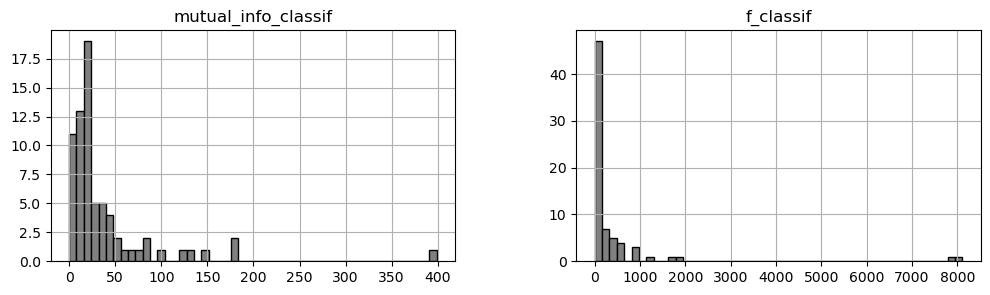

In [58]:
best_features.hist(bins=50, color='grey', ec='k')
plt.gcf().set_size_inches(12,3)

We drop the features that have both low mutual information factor and ANOVA f_score with the target.

In [59]:
factor = 50
# boolean masks to select features to be dropped
cond1 = best_features['mutual_info_classif']<best_features['mutual_info_classif'].std()/factor
cond2 = best_features['f_classif']<best_features['f_classif'].std()/factor
worst_feat = best_features.loc[cond1&cond2]
worst_feat

,mutual_info_classif,f_classif
Bur_CB_CREDIT_DAY_OVERDUE__sum,0.00,7.97
Bur_CB_CNT_CREDIT_PROLONG__mean,0.00,0.57
Bur_CB_AMT_CREDIT_SUM_DEBT__sum,0.00,1.10


In [60]:
# drop features with low scores

quant_cols = [col for col in quant_cols if col not in worst_feat]

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

### Permutation importance (model based)

In [61]:
# encode the dataset

import warnings
warnings.filterwarnings('ignore')

ct = CustTransformer(thresh_card=8,
                     strat_quant='stand',
                     strat_binary='ord',
                     strat_low_card='loo',
                     strat_high_card='loo')

X_train_enc = pd.DataFrame(ct.fit_transform(X_train, y_train),
                          index=X_train.index) # y_train is here for 'loo' encoding

In [93]:
# select a sample in order to speed up the calculations and reduce imbalance

ind0 = y_train[y_train==0].sample(40000).index
ind1 = y_train[y_train==1].index

samp_ind = list(set(list(ind0)+list(ind1)))

X_train_samp = X_train.loc[samp_ind]
X_train_enc_samp = X_train_enc.loc[samp_ind]
y_train_samp = y_train.loc[samp_ind]

In [94]:
X_train_samp = X_train_samp.head(20000)
X_train_enc_samp = X_train_enc_samp.head(20000)
y_train_samp = y_train_samp.head(20000)
y_train_samp.value_counts()

TARGET
0         18422
1          1578
dtype: int64

In [95]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


In [96]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_enc_samp, y_train_samp)
# result_lgbm = permutation_importance(lgbm, X_train_enc_samp, y_train_samp, n_repeats=10, random_state=14, verbose=3)
result_lgbm = permutation_importance(lgbm, X_train_enc_samp, y_train_samp, n_repeats=10, random_state=14)

rf = RandomForestClassifier()
rf.fit(X_train_enc_samp, y_train_samp)
# result_rf = permutation_importance(rf, X_train_enc_samp, y_train_samp, n_repeats=10, random_state=14, verbose=3)
result_rf = permutation_importance(rf, X_train_enc_samp, y_train_samp, n_repeats=10, random_state=14)

feat_imp_permut_df = pd.DataFrame({'LGBM': result_lgbm.importances_mean*1000,
                                   'RF': result_rf.importances_mean*1000},
                                  index=X_train_enc_samp.columns)

In [97]:
display(feat_imp_permut_df.sort_values('LGBM'))

,LGBM,RF
PA_PrLCash_SK_DPD__mean__mean,-0.78,0.46
low_card__NAME_TYPE_SUITE,-0.05,0.33
PA_PrL_N_CONT_St_Completed__sum,0.00,0.19
PA_PrLCash_N_CONTR_ST_Demand__sum__sum,0.00,0.05
PA_PrL_N_PORTF_Cards__sum,0.02,0.05
PA_PrL_N_PORTF_Cash__sum,0.03,0.15
AMT_REQ_CREDIT_BUREAU_MON,0.07,0.17
PA_PrLCash_N_CONTR_ST_Signed__sum__sum,0.07,0.13
Bur_CB_CR_TY_Car loan__sum,0.08,0.05
Bur_CB_CR_TY_Mortgage__sum,0.10,0.05


In [164]:
# boolean masks to select features to be dropped
# find n less important features according to both models

n=82
less_perm_imp_feat = feat_imp_permut_df
factors = np.logspace(0,4,30)#.astype('int')
cpt = 0
while less_perm_imp_feat.shape[0]>=n:
    print(cpt, less_perm_imp_feat.shape)
    # boolean masks to select features to be dropped
    cond1 = feat_imp_permut_df['LGBM']<feat_imp_permut_df['LGBM'].std()/factors[cpt]
    cond2 = feat_imp_permut_df['RF']<feat_imp_permut_df['RF'].std()/factors[cpt]
    less_perm_imp_feat = feat_imp_permut_df.loc[cond1&cond2]
    cpt += 1

less_perm_imp_feat

0 (82, 2)


,LGBM,RF
binary__NAME_CONTRACT_TYPE,1.16,0.01
binary__FLAG_OWN_CAR,0.15,0.00
binary__FLAG_OWN_REALTY,0.11,0.01
low_card__NAME_TYPE_SUITE,-0.05,0.33
low_card__NAME_INCOME_TYPE,0.76,0.78
low_card__NAME_FAMILY_STATUS,1.10,0.38
low_card__NAME_HOUSING_TYPE,0.19,0.33
high_card__OCCUPATION_TYPE,1.33,2.56
high_card__ORGANIZATION_TYPE,2.32,5.15
Bur_CB_AMT_CREDIT_MAX_OVERDUE__max,0.31,1.12


### Selection based on feature importance of a bagging model and a boosting model

In [165]:
# initialize and train
rf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=2,
                            max_samples=3, random_state=14)
lgbm = LGBMClassifier()

rf.fit(X_train_enc_samp, y_train_samp)
lgbm.fit(X_train_enc_samp, y_train_samp)

LGBMClassifier()

In [166]:
f_feat_imp_df = pd.DataFrame({'LGBM': rf.feature_importances_*1000,
                              'RF': lgbm.feature_importances_},
                             index=X_train_enc_samp.columns)

In [167]:
f_feat_imp_df.sort_values('LGBM')

,LGBM,RF
Bur_CB_CR_TY_Mortgage__sum,0.00,1
low_card__NAME_TYPE_SUITE,0.00,6
Bur_CB_CR_TY_Car loan__sum,0.00,5
Bur_CB_CR_TY_Microloan__sum,0.00,9
Bur_CB_CREDIT_DAY_OVERDUE__sum,0.00,2
Bur_CB_AMT_CREDIT_SUM_OVERDUE__sum,0.00,7
PA_PrLCash_N_CONTR_ST_Demand__sum__sum,0.00,0
PA_PrL_N_PORTF_Cash__sum,2.12,3
PA_PrL_N_PORTF_Cards__sum,2.12,1
Bur_CB_STATUS__size__sum,2.12,28


In [168]:
# find n less important features according to both models

less_imp_feat = f_feat_imp_df
print (less_imp_feat.shape[0])

82


In [169]:
factors = np.logspace(0,3,30)#.astype('int')
cpt = 0
while less_imp_feat.shape[0]>=82:
    print (less_imp_feat.shape[0])
    cpt += 1
    # boolean masks to select features to be dropped
    cond1 = f_feat_imp_df['LGBM']<f_feat_imp_df['LGBM'].std()/factors[cpt]
    cond2 = f_feat_imp_df['RF']<f_feat_imp_df['RF'].std()/factors[cpt]
    less_imp_feat = f_feat_imp_df.loc[cond1&cond2]
    
less_imp_feat

82


,LGBM,RF
binary__NAME_CONTRACT_TYPE,2.12,13
low_card__NAME_TYPE_SUITE,0.00,6
low_card__NAME_FAMILY_STATUS,4.25,14
low_card__NAME_HOUSING_TYPE,6.37,8
Bur_CB_AMT_CREDIT_MAX_OVERDUE__max,4.25,18
PA_PrLCash_N_CONTR_ST_Demand__sum__sum,0.00,0
Bur_CB_AMT_CREDIT_SUM_OVERDUE__sum,0.00,7
Bur_CB_CREDIT_DAY_OVERDUE__sum,0.00,2
Bur_CB_CR_TY_Microloan__sum,0.00,9
Bur_CB_CNT_CREDIT_PROLONG__mean,2.12,8


### Compare the ranking of  feature importance

In [170]:
non_imp_feat = list(set(less_imp_feat.index) & set(less_perm_imp_feat.index))
non_imp_feat

['AMT_REQ_CREDIT_BUREAU_QRT',
 'PA_PrLCash_N_CONTR_ST_Signed__sum__sum',
 'low_card__NAME_TYPE_SUITE',
 'low_card__NAME_FAMILY_STATUS',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'PA_PrLCash_N_CONTR_ST_Demand__sum__sum',
 'binary__NAME_CONTRACT_TYPE',
 'PA_PrL_N_CONT_St_Completed__sum',
 'Bur_CB_AMT_CREDIT_SUM_OVERDUE__sum',
 'Bur_CB_ST__mode_N__sum',
 'CNT_CHILDREN',
 'Bur_CB_CREDIT_DAY_OVERDUE__sum',
 'Bur_CB_ST__mode_X__sum',
 'Bur_CB_AMT_CREDIT_SUM_LIMIT__sum',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'Bur_CB_CR_TY_Mortgage__sum',
 'Bur_CB_CR_TY_Car loan__sum',
 'PA_PrL_N_PORTF_Cash__sum',
 'PA_PrLCash_SK_DPD__mean__mean',
 'PA_PrL_N_PORTF_Cards__sum',
 'low_card__NAME_HOUSING_TYPE',
 'Bur_CB_AMT_CREDIT_MAX_OVERDUE__max',
 'Bur_CB_CNT_CREDIT_PROLONG__mean',
 'Bur_CB_CR_TY_Microloan__sum']

In [171]:
# # compare

# high_corr_df = pd.Series(np.ones(len(high_corr_cols)),
#                         index=high_corr_cols,
#                         name='high_corr').to_frame()
# low_var_df = pd.Series(np.ones(len(low_var_cols)),
#                        index=low_var_cols,
#                        name='low_var').to_frame()
# high_vip_df = pd.Series(np.ones(len(high_vip_cols)),
#                         index=high_vip_cols,
#                         name='high_vip').to_frame()

# pd.concat([high_corr_df, low_var_df, high_vip_df], axis=1).replace({1:True,
#                                                                     np.nan:False})

Drop the least important features for both models

In [172]:
# keep 'variables' among 'quant_cols' (include only quantitative features with VIF lower than 30)
quant_cols = [col for col in quant_cols if col not in non_imp_feat]

X_train = X_train[quant_cols+cat_cols]
X_test = X_test[quant_cols+cat_cols]

In [173]:
X_train[cat_cols]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,,,,
100002,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Business Entity Type 3
100003,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,School
100004,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Government
100006,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,Business Entity Type 3
100007,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,Religion
...,...,...,...,...,...,...,...,...,...,...,...
456251,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,Services
456252,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Laborers,XNA
456253,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,School


## 4 Save Data

In [174]:
X_train.shape, X_test.shape, y_train.shape

((307511, 61), (48744, 61), (307511, 1))

In [175]:
dict_cleaned = {'X_train': X_train,
                'y_train': y_train['TARGET'],
                'X_test': X_test}

In [176]:
### Pickling the aggregated dataset

import dill

with open('../data/cleaned/dict_cleaned.pkl', 'wb') as file:
    dill.dump(dict_cleaned, file)